# **Local Interpretable Model-agnostic Explanations (LIME)**

Ressources :
- [Papier présentant LIME](https://arxiv.org/pdf/1602.04938.pdf)
- [Github officiel de LIME](https://github.com/marcotcr/lime)  
- [LIME Tutorial - images - Pytorch](https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20images%20-%20Pytorch.ipynb)

Comme les auteurs de LIME le dévrivent dans le papier, pour *croire* aux expliquations fournient par un modèle de type back-box, comprendre la façon dont se dernier prend ses déçisions est crucial. Comparer ces explications aux croyances à priori de l'observateur permet d'accepter plus simplement la validité d'un modèle.  
  
LIME entend fournir aux utilisateurs une explication *compréhensible*. Dans le cadre du traitement d'image, les modèles prédictifs recoivent en entrée des tableaux de taille (m x n) indiquant l'intensité des pixels sur chaque couche k (k=3 pour le RGB). L'input d'un modèle est donc de (m x n x k) valeurs, venir cibler un input précisement ayant joué un grand rôle dans l'attribution du label est donc peine perdue.  
  
Pour rendre cette information compréhensible, LIME traite des *superpixels*, i.e. des parties entière de l'image traitée correspondant aux k couches et d'une taille (m' * n'). De cette façon, l'utilisateur est capable d'analyser les parties de l'images ayant eu un fort impact dans l'attribution du label par le modèle.

### **Sélection des images**

Nous sélectionnons plusieurs images de notre échantillon test labellisée `0` (non-détruit) et `1` (détruit) avant de les passer à nos deux modèles pour effectuer une prédiction. Nous comparons les outputs obtenus avec leur labels associés aux images avant d'analyser la façon dont le modèle prend sa déçision à l'aide de LIME.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.autograd import Variable
import torch.nn.functional as F

In [2]:
DATA_DIR = '../../data/'
DATA_TEST_DIR = os.path.join(DATA_DIR, 'images/all/test')
PROCESS_DIR = os.path.join(DATA_DIR, 'process')
MODEL_DIR = os.path.join(DATA_DIR, 'model')
GRAPH_DIR = os.path.join(DATA_DIR, 'graphs')

os.makedirs(GRAPH_DIR, exist_ok=True)
np.random.seed(42)

In [3]:
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 

In [4]:
liste_images_0 = [f for f in os.listdir(os.path.join(DATA_TEST_DIR, "0")) if os.path.isfile(os.path.join(os.path.join(DATA_TEST_DIR, "0"), f))]
liste_images_1 = [f for f in os.listdir(os.path.join(DATA_TEST_DIR, "1")) if os.path.isfile(os.path.join(os.path.join(DATA_TEST_DIR, "1"), f))]

print("Nombre d'images par label :\n - 0 (non-détruit) = {}\n - 1 (détruit) = {}".format(len(liste_images_0),
                                                                                         len(liste_images_1)))

Nombre d'images par label :
 - 0 (non-détruit) = 1336
 - 1 (détruit) = 801


In [5]:
def random_image(label):
    """ Choix aleatoire d'une image presente dans l'echantillon
        test du label choisi.
        Retourne une image.
    """
    if label == 0:
        rnd = np.random.randint(len(liste_images_0))
        rnd_image = liste_images_0[rnd]
        return get_image(os.path.join(os.path.join(DATA_TEST_DIR, "0"), rnd_image))
    elif label == 1:
        rnd = np.random.randint(len(liste_images_1))
        rnd_image = liste_images_1[rnd]
        return get_image(os.path.join(os.path.join(DATA_TEST_DIR, "1"), rnd_image))
    else:
        print('Label incorrecte')

In [6]:
img_0_a = random_image(0)
img_0_b = random_image(0)
img_1_a = random_image(1)
img_1_b = random_image(1)

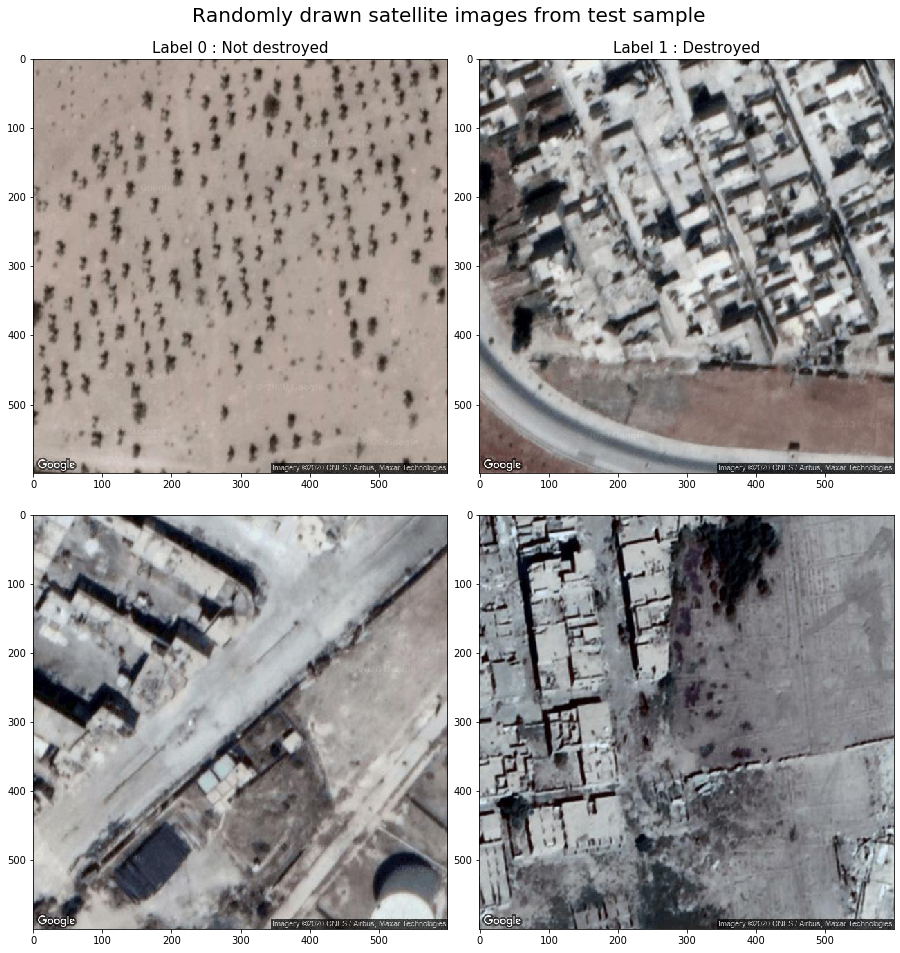

In [7]:
plt.figure(figsize=(16, 16))

ax1 = plt.subplot(221)
ax1.imshow(img_0_a)
ax1.set_title("Label 0 : Not destroyed", fontsize=15)

ax2 = plt.subplot(222)
ax2.imshow(img_1_a)
ax2.set_title("Label 1 : Destroyed", fontsize=15)

ax1 = plt.subplot(223)
ax1.imshow(img_0_b)

ax2 = plt.subplot(224)
ax2.imshow(img_1_b)

plt.suptitle("Randomly drawn satellite images from test sample", 
             fontsize=20, y=0.925)
plt.subplots_adjust(wspace=0, hspace=0.1)
plt.savefig(os.path.join(GRAPH_DIR, 'model_prediction_alep.jpg'), optimize=True, quality=95)
plt.show()

### **Retraitement préalable des images avant prédiction**

In [8]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('%d GPU(s) disponible.' % torch.cuda.device_count())
    print('GPU utilisé :', torch.cuda.get_device_name(0))

else:
    print('Pas de GPU disponible, utilisation du CPU.')
    device = torch.device("cpu")

1 GPU(s) disponible.
GPU utilisé : GeForce GTX 1050 Ti


Nous appliquons les transformations nécessaires à nos images (normalisation et tensorisation) avant de les envoyer en input de nos modèles.

In [9]:
def get_input_transform():   
    transf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])    

    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    return transf(img).unsqueeze(0) # batch de 1 image

### **Importation des modèles et prédiction**

In [10]:
model_euroSAT = models.resnet50(pretrained=False, progress=True)
num_ftrs = model_euroSAT.fc.in_features
model_euroSAT.fc = nn.Linear(num_ftrs, 2)
model_euroSAT.load_state_dict(torch.load(os.path.join(MODEL_DIR, 'all_model_euroSAT.pt')))

model_no_euroSAT = models.resnet50(pretrained=False, progress=True)
num_ftrs = model_no_euroSAT.fc.in_features
model_no_euroSAT.fc = nn.Linear(num_ftrs, 2)
model_no_euroSAT.load_state_dict(torch.load(os.path.join(MODEL_DIR, 'all_model_no_euroSAT.pt')))

<All keys matched successfully>

Prédiction sur les 4 images par les deux modèles.

In [11]:
def prediction_image(image, model):
    """ Sort les predictions d'un model sur l'image
        passee en arguement.
    """
    model_d = model.to(device)
    
    img_t = get_input_tensors(image)
    img_t = img_t.to(device)
    model.eval()
    logits = model(img_t)
    
    probs = F.softmax(logits, dim=1)
    probs = (probs.detach().cpu().numpy())
    
    return probs

Label = 0



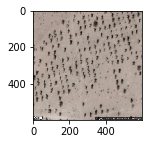

Probabilité que la zone contienne un bâtiment détruit :
model_no_euroSAT : 6.67 %
model_euroSAT : 4.66 %



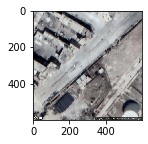

Probabilité que la zone contienne un bâtiment détruit :
model_no_euroSAT : 30.15 %
model_euroSAT : 32.56 %



In [12]:
print("Label = 0\n")

for img in [img_0_a, img_0_b]:
    pred_no_euroSAT = prediction_image(img, model_no_euroSAT)[0][1] * 100
    pred_euroSAT = prediction_image(img, model_euroSAT)[0][1] * 100
    plt.figure(figsize=(2, 2))
    plt.imshow(img)
    plt.show()
    print("Probabilité que la zone contienne un bâtiment détruit :")
    print("model_no_euroSAT : {} %".format(round(pred_no_euroSAT, 2)))
    print("model_euroSAT : {} %\n".format(round(pred_euroSAT, 2)))

Label = 1



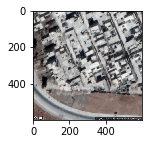

Probabilité que la zone contienne un bâtiment détruit
model_no_euroSAT : 92.62 %
model_euroSAT : 90.91 %



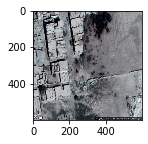

Probabilité que la zone contienne un bâtiment détruit
model_no_euroSAT : 64.3 %
model_euroSAT : 43.86 %



In [13]:
print("Label = 1\n")

for img in [img_1_a, img_1_b]:
    pred_no_euroSAT = prediction_image(img, model_no_euroSAT)
    pred_euroSAT = prediction_image(img, model_euroSAT)
    pred_no_euroSAT = pred_no_euroSAT[0][1] * 100
    pred_euroSAT = pred_euroSAT[0][1] * 100
    plt.figure(figsize=(2, 2))
    plt.imshow(img)
    plt.show()
    print("Probabilité que la zone contienne un bâtiment détruit")
    print("model_no_euroSAT : {} %".format(round(pred_no_euroSAT, 2)))
    print("model_euroSAT : {} %\n".format(round(pred_euroSAT, 2)))

### **Retraitement des images pour LIME**

In [14]:
def get_preprocess_transform():    
    transf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])    

    return transf    

preprocess_transform = get_preprocess_transform()

Création de la fonction `batch_predict` qui viendra charger les images bruitées par mini-batch sur le GPU.

In [15]:
def batch_predict_model_no_euroSAT(images):
    results = np.empty(len(images)*2, dtype=np.float32).reshape(len(images), 2)
    model_no_euroSAT.eval()
    
    for i in range(len(images)):
        batch = preprocess_transform(images[i]).unsqueeze(0)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model_no_euroSAT.to(device)
        batch = batch.to(device)
        logits = model_no_euroSAT(batch)               
        probs = F.softmax(logits, dim=1)
        results[i] = probs.detach().cpu().numpy()[0]
                      
    return results

In [16]:
def batch_predict_model_euroSAT(images):
    results = np.empty(len(images)*2, dtype=np.float32).reshape(len(images), 2)
    model_euroSAT.eval()
    
    for i in range(len(images)):
        batch = preprocess_transform(images[i]).unsqueeze(0)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model_euroSAT.to(device)
        batch = batch.to(device)
        logits = model_euroSAT(batch)               
        probs = F.softmax(logits, dim=1)
        results[i] = probs.detach().cpu().numpy()[0]
                      
    return results

On importe le package LIME disponible en opensource sur cette page [Github](https://github.com/marcotcr/lime)  

In [17]:
from lime import lime_image

### **Instanciation des explications LIME**

On commence par instancer le modèle explicatif grace à la classe `LimeImageExplainer` spécialisée dans l'explication des prises de décisions traitant des images.  
  
On envoi ensuite une de nos images, via l'argument `image`, dont on souhaiterait connaitre les *superpixels* ayant orientés la prise de décision (le choix du label) du modèle, via l'argument `classifier_fn`. L'argument `num_sample` joue un rôle crucial, il décide de la taille de l'échantillon d'images perturbée que nous allons envoyer au classifier. Plus son nombre est élevé, plus l'importance qu'a joué l'un des superpixels dans la prise de décision est précise. Nous laissons sa valeur par défaut qui est de 1000. Cependant, le nombre d'image bruitées généré est trop élevé pour rentrer dans la RAM du GPU. Nous devons donc utiliser les fonctions `batch_predict_model_no_euroSAT` et `batch_predict_model_euroSAT`, utilisant respectivement model_no_euroSAT et model_euroSAT, pour charger les images une à une.

In [18]:
explainer = lime_image.LimeImageExplainer()

### **Affichage des explications de LIME**

In [19]:
from skimage.segmentation import mark_boundaries

In [20]:
def affichage_explication(img, model):
    explanation = explainer.explain_instance(image=np.array(img), 
                                             classifier_fn=model,
                                             labels=(1, 0), 
                                             hide_color=0, 
                                             num_samples=1000)

    print("Label prédit par le modèle : {}".format(explanation.top_labels[0]))

    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False,
                                                num_features=5, hide_rest=False)

    plt.figure(figsize=(20, 20))
    img_boundry = mark_boundaries(temp/255.0, mask)
    ax1 = plt.subplot(121)
    ax1.imshow(img_boundry)
    ax2 = plt.subplot(122)
    ax2.imshow(img)

    plt.show()

- Image `img_0_a` classée 0

Modèle non pretrained :


Label prédit par le modèle : 0


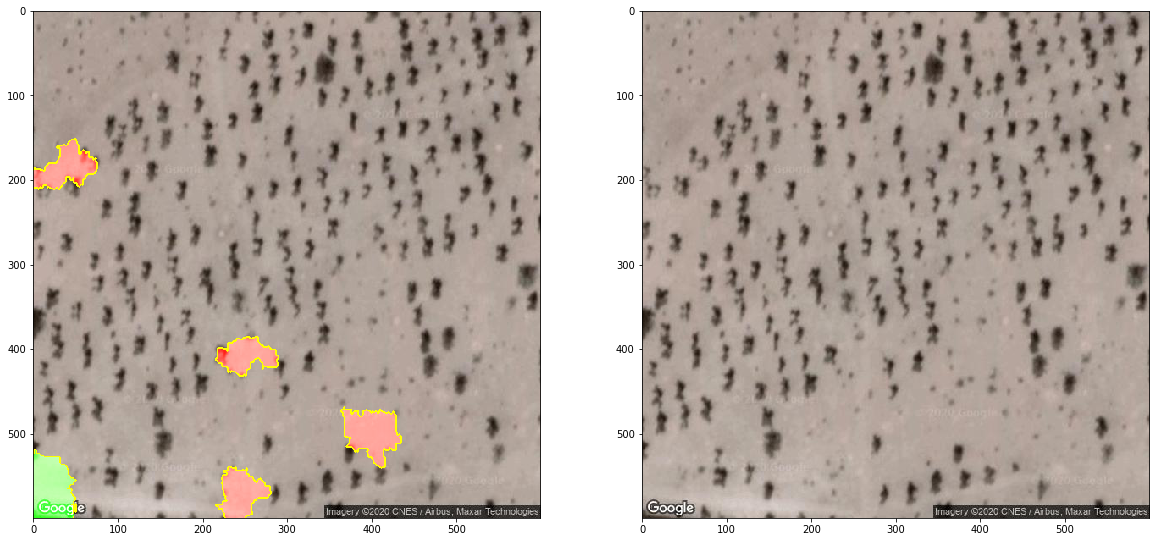

In [22]:
affichage_explication(img_0_a, batch_predict_model_no_euroSAT)

Modèle pretrained :


Label prédit par le modèle : 0


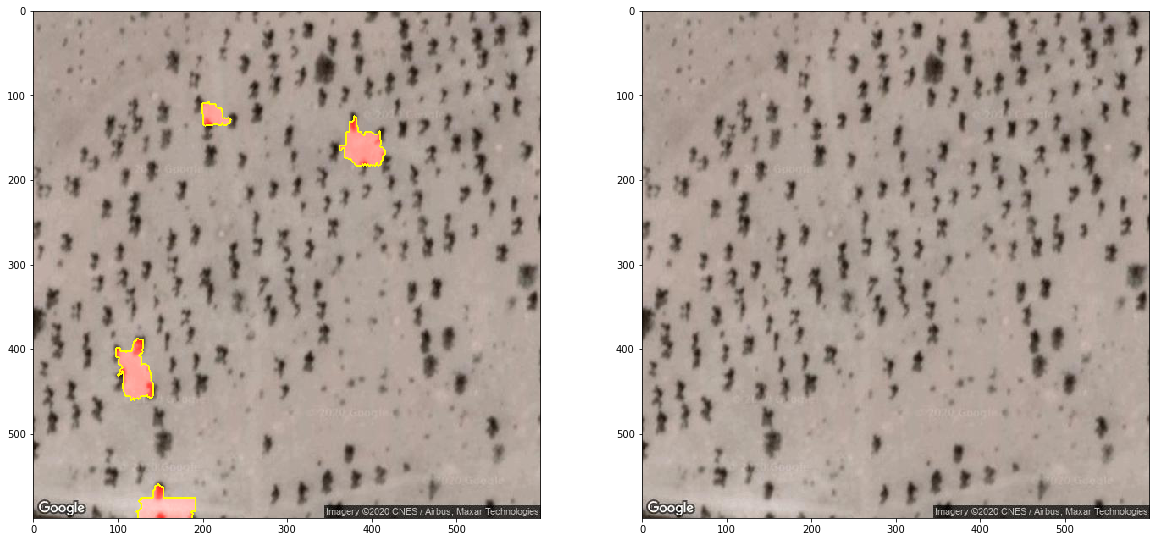

In [23]:
affichage_explication(img_0_a, batch_predict_model_euroSAT)

- Image `img_0_b` classée 0

Modèle non pretrained :


Label prédit par le modèle : 0


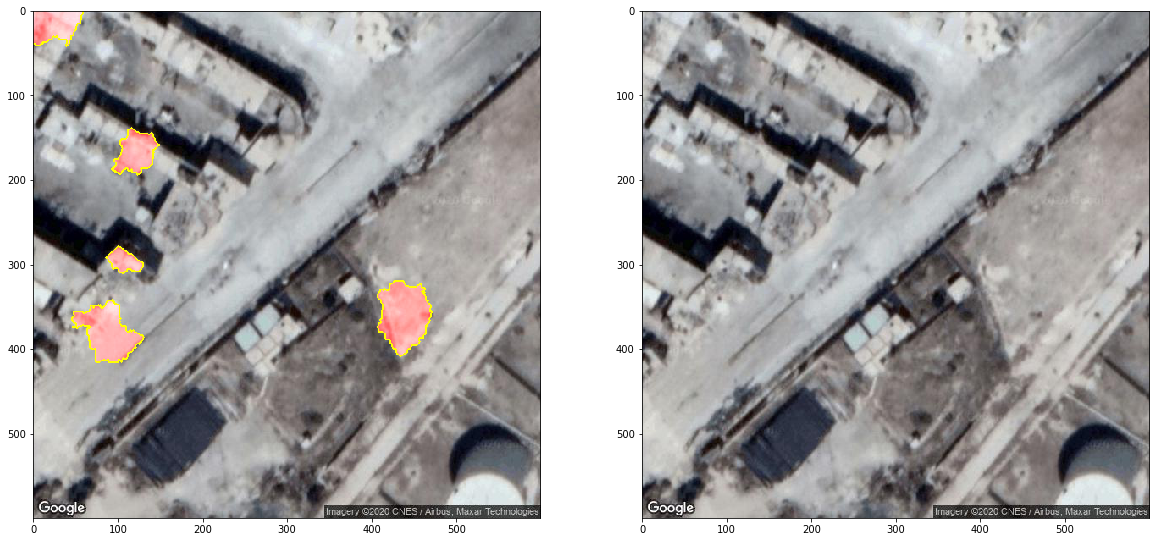

In [30]:
affichage_explication(img_0_b, batch_predict_model_no_euroSAT)

Modèle pretrained :


Label prédit par le modèle : 0


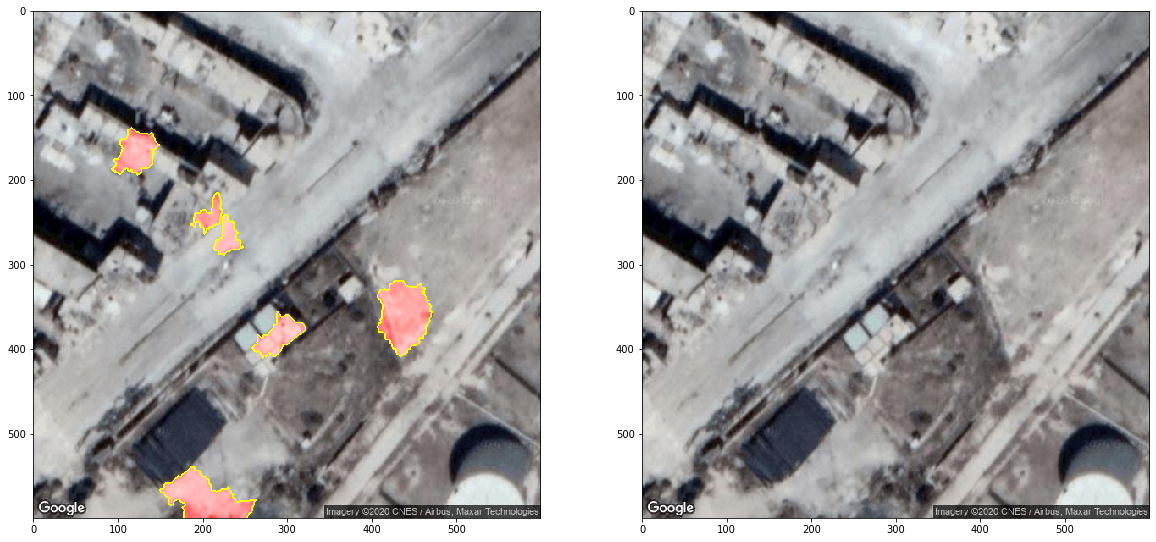

In [25]:
affichage_explication(img_0_b, batch_predict_model_euroSAT)

- Image `img_1_a` classée 1

Modèle non pretrained :


Label prédit par le modèle : 1


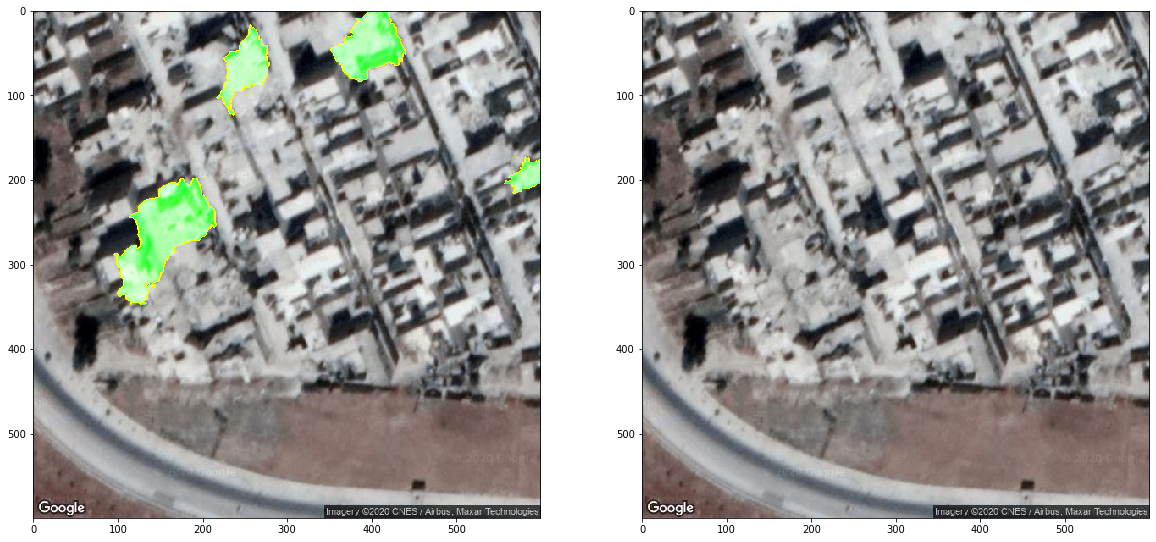

In [26]:
affichage_explication(img_1_a, batch_predict_model_no_euroSAT)

Modèle pretrained :


Label prédit par le modèle : 1


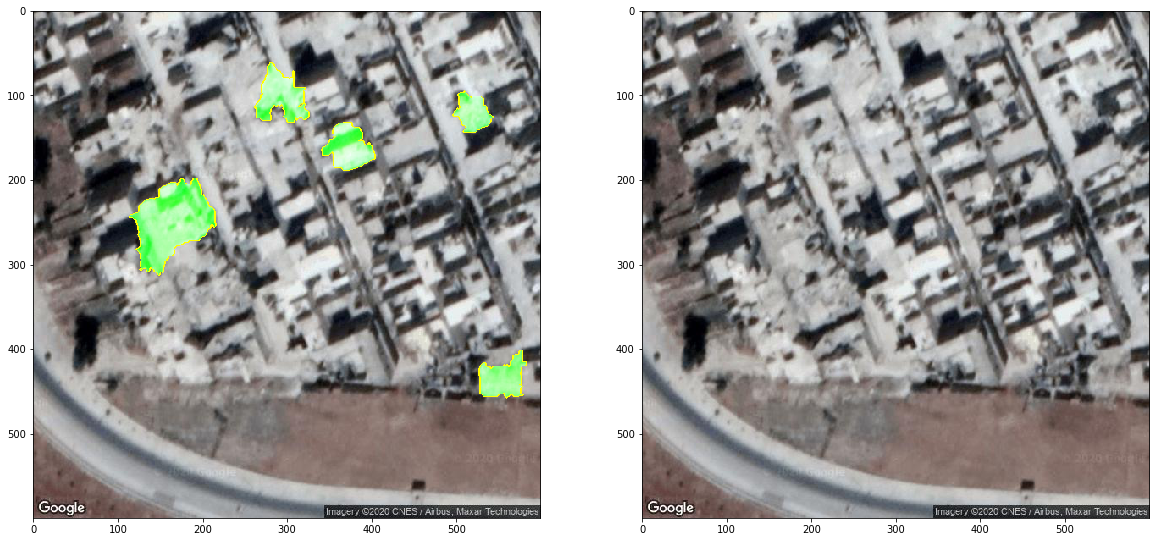

In [27]:
affichage_explication(img_1_a, batch_predict_model_euroSAT)

- Image `img_1_b` classée 1

Modèle non pretrained :


Label prédit par le modèle : 1


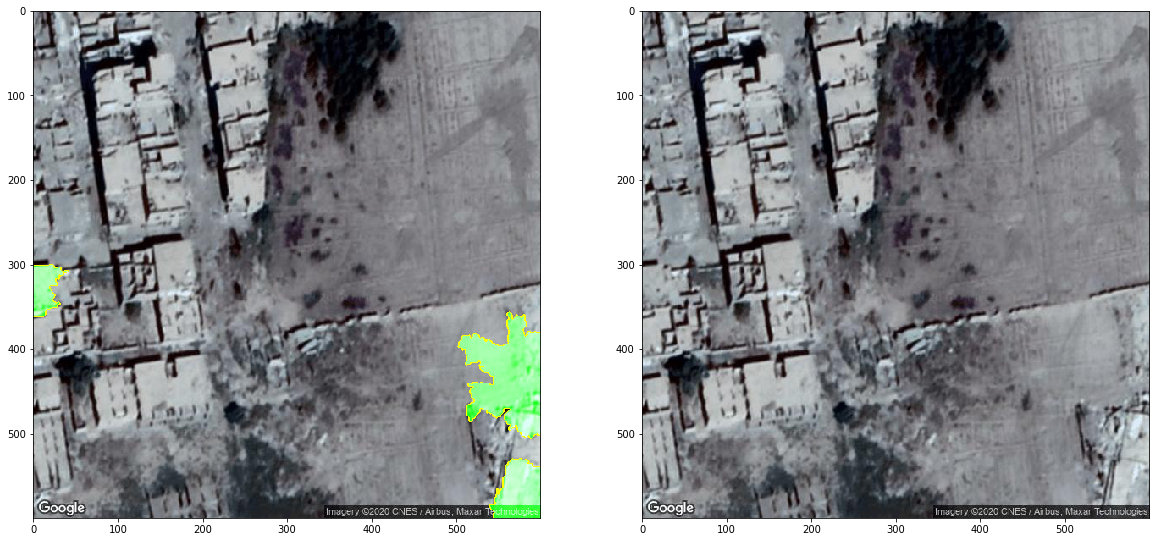

In [28]:
affichage_explication(img_1_b, batch_predict_model_no_euroSAT)

Modèle pretrained :


Label prédit par le modèle : 0


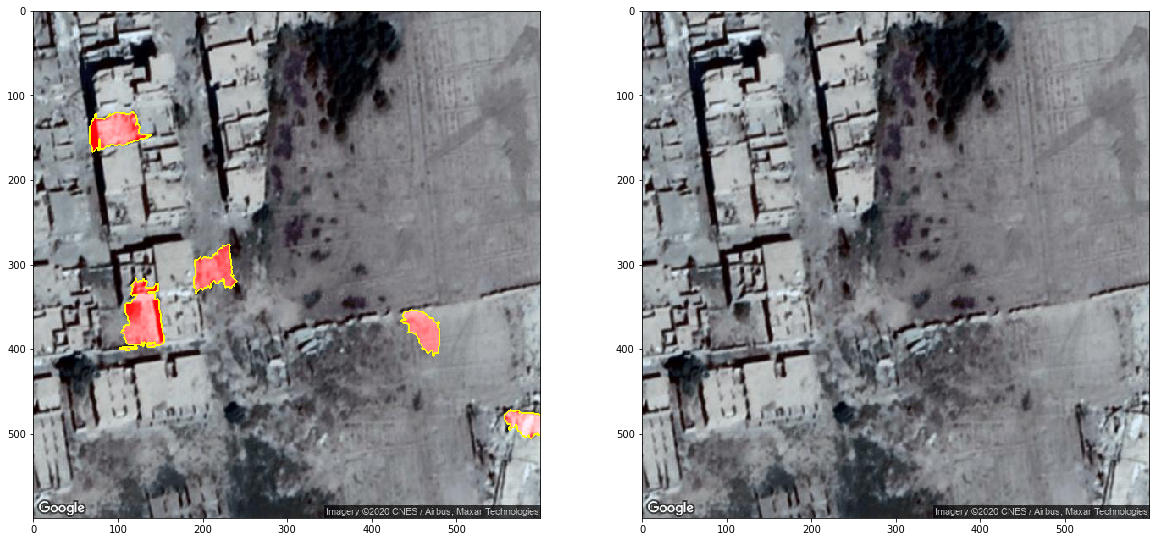

In [29]:
affichage_explication(img_1_b, batch_predict_model_euroSAT)